In [1]:
import numpy as np
import pandas as pd
import random
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from tensorflow.keras.layers import *
from arch import arch_model
from arch.univariate import ZeroMean, GARCH, StudentsT, ConstantMean
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.preprocessing import MinMaxScaler
plt.style.use("fivethirtyeight")

2023-05-21 15:59:41.258505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('yahoo_stock.csv', parse_dates = ['Date'], index_col = 'Date')

In [3]:
df

High          Low         Open        Close        Volume   
Date                                                                           
2015-11-23  2095.610107  2081.389893  2089.409912  2086.590088  3.587980e+09  \
2015-11-24  2094.120117  2070.290039  2084.419922  2089.139893  3.884930e+09   
2015-11-25  2093.000000  2086.300049  2089.300049  2088.870117  2.852940e+09   
2015-11-26  2093.000000  2086.300049  2089.300049  2088.870117  2.852940e+09   
2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107  1.466840e+09   
...                 ...          ...          ...          ...           ...   
2020-11-16  3628.510010  3600.159912  3600.159912  3626.909912  5.281980e+09   
2020-11-17  3623.110107  3588.679932  3610.310059  3609.530029  4.799570e+09   
2020-11-18  3619.090088  3567.330078  3612.090088  3567.790039  5.274450e+09   
2020-11-19  3585.219971  3543.840088  3559.409912  3581.870117  4.347200e+09   
2020-11-20  3581.229980  3556.850098  3579.310059  3557.540039  2.236662e+09   

              Adj Close  
Date                     
2015-11-23  2086.590088  
2015-11-24  2089.139893  
2015-11-25  2088.870117  
2015-11-26  2088.870117  
2015-11-27  2090.110107  
...                 ...  
2020-11-16  3626.909912  
2020-11-17  3609.530029  
2020-11-18  3567.790039  
2020-11-19  3581.870117  
2020-11-20  3557.540039  

[1825 rows x 6 columns]

In [4]:
print(df.index.min())
print(df.index.max())

2015-11-23 00:00:00
2020-11-20 00:00:00


In [5]:
df.shape

(1825, 6)

<Axes: xlabel='Date'>

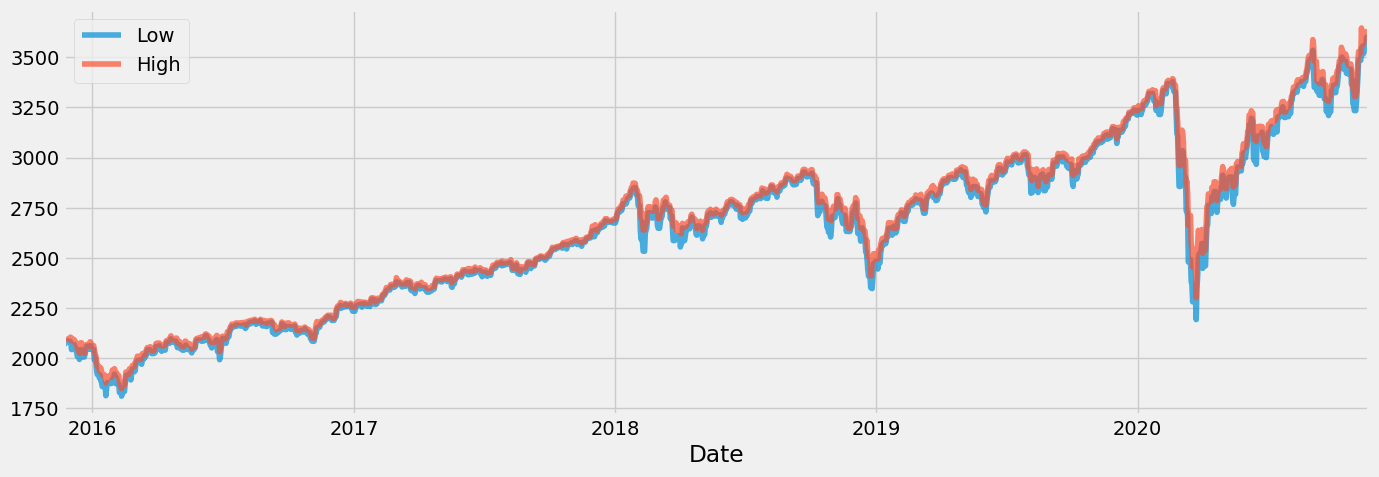

In [6]:
df[['Low', 'High']].plot(figsize = (15, 5), alpha = 0.7)

<Axes: xlabel='Date'>

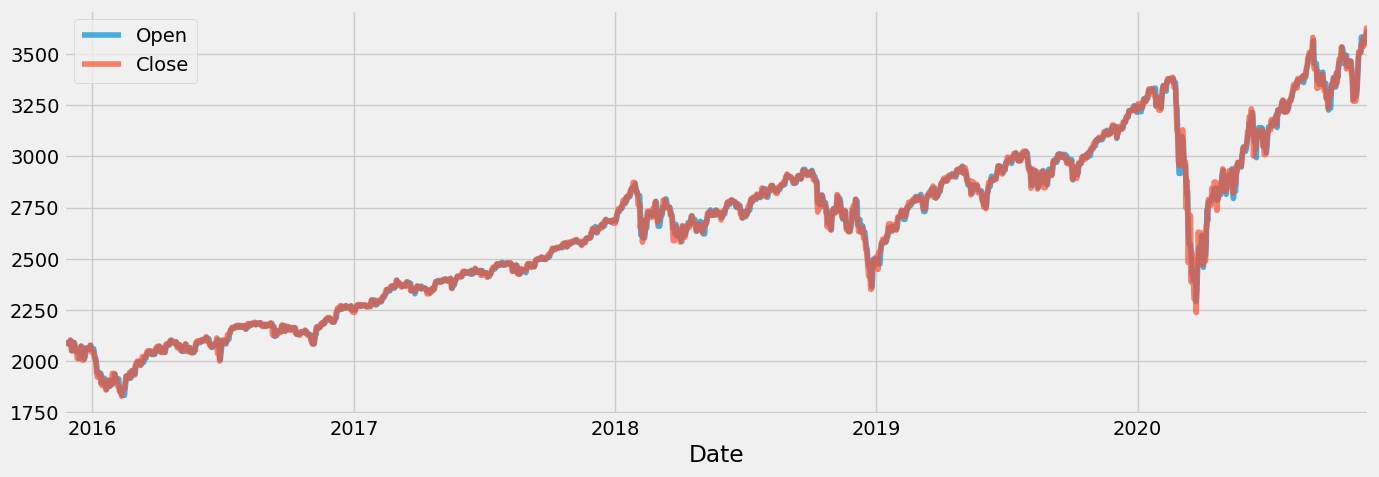

In [7]:
df[['Open', 'Close']].plot(figsize = (15, 5), alpha = 0.7)

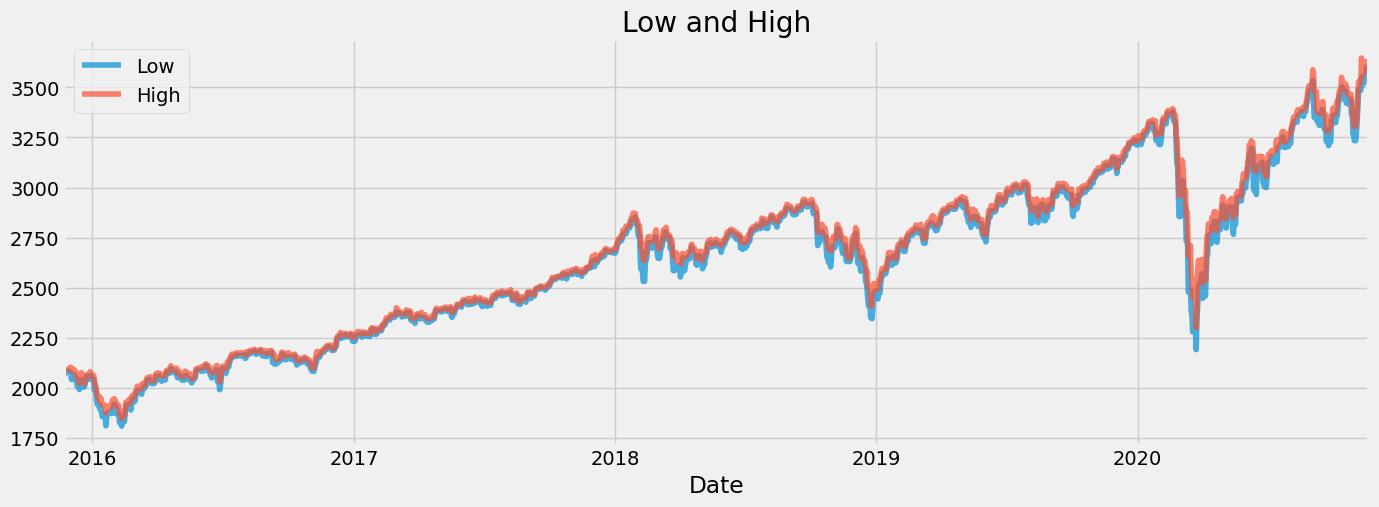

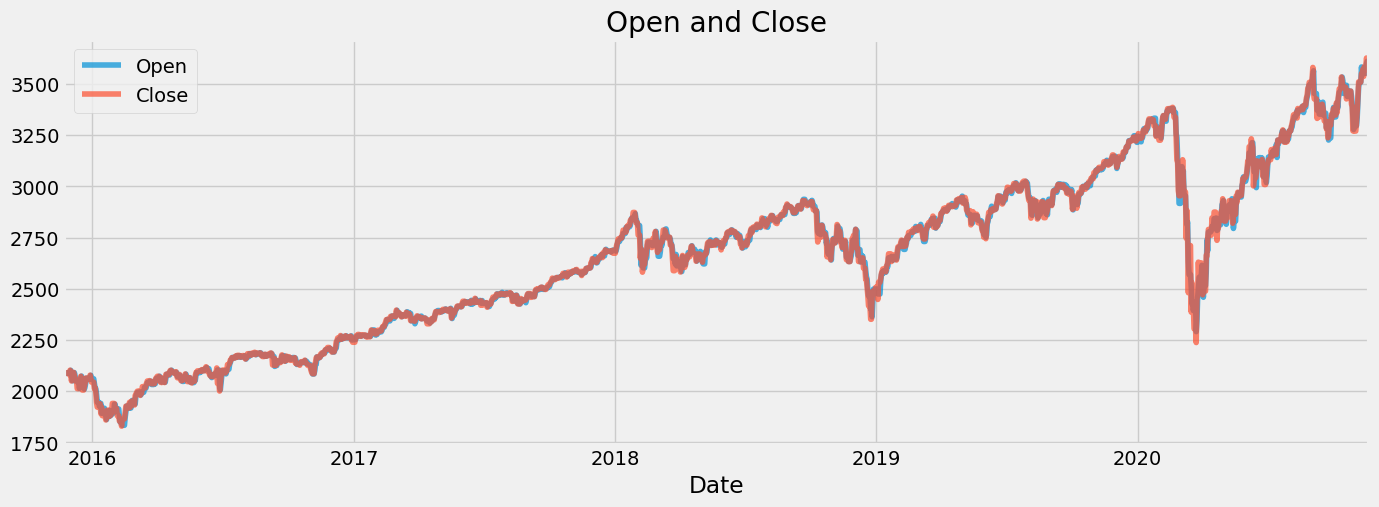

In [11]:
# Plotting the first graph (Low and High)
fig, ax1 = plt.subplots(figsize=(15, 5))
df[['Low', 'High']].plot(ax=ax1, alpha=0.7)
ax1.set_title('Low and High')

# Plotting the second graph (Open and Close)
fig, ax2 = plt.subplots(figsize=(15, 5))
df[['Open', 'Close']].plot(ax=ax2, alpha=0.7)
ax2.set_title('Open and Close')

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.5)

# Display the plots
plt.show()

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(df, column_name):
    result_mul = seasonal_decompose(df[column_name], model='multiplicative', extrapolate_trend = 'freq')
    result_add = seasonal_decompose(df[column_name], model = 'additive', extrapolate_trend='freq')

    plt.rcParams.update({'figure.figsize': (12, 6)})
    result_mul.plot().suptitle('Multiplicative Decompose', y=1.02, fontsize=20)
    result_add.plot().suptitle('Additive Decompose', y=1.02, fontsize=20)
    plt.show()
    
    return result_mul, result_add

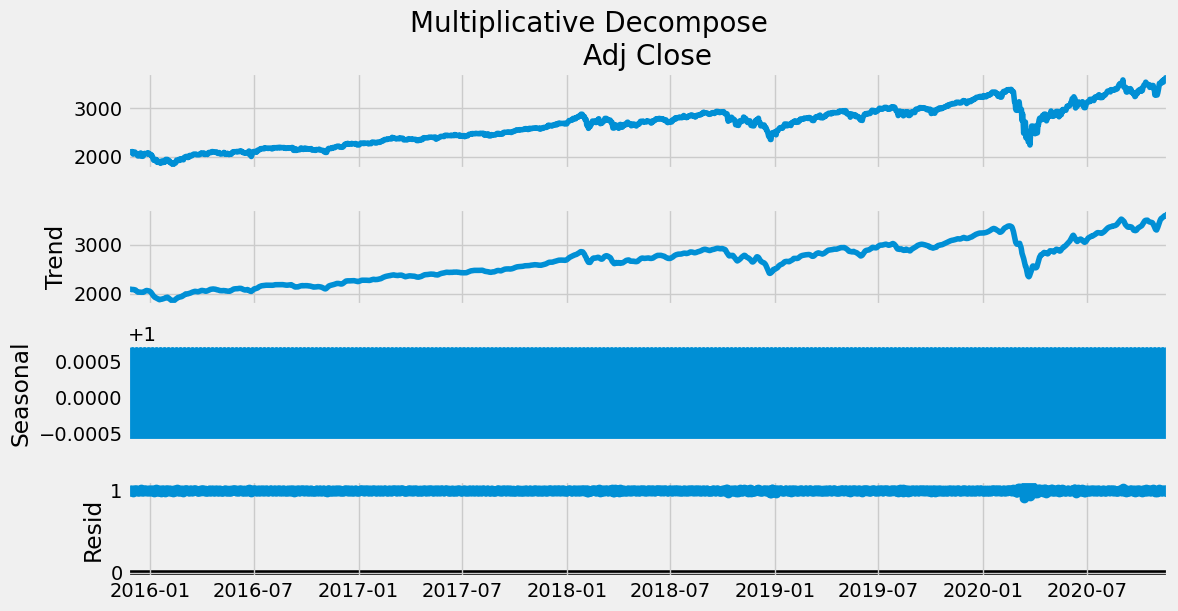

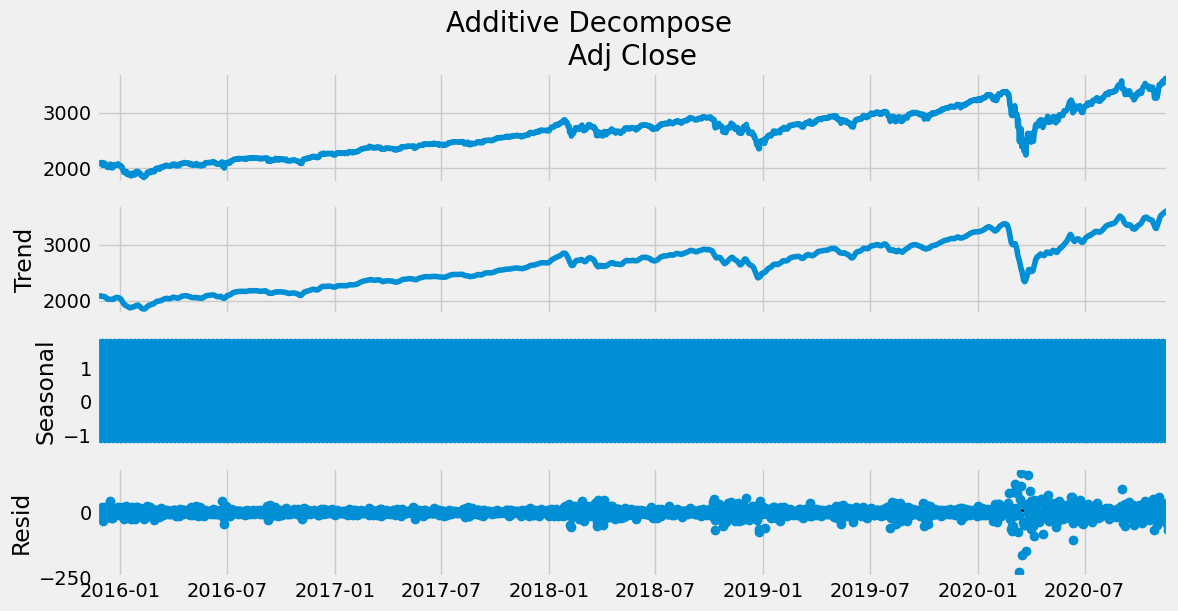

In [45]:
result_mul, result_add = decompose(df, 'Adj Close')

In [47]:
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis = 1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed

seas        trend      resid  actual_values
Date                                                       
2015-11-23 -1.164921  2093.707970  -5.952962    2086.590088
2015-11-24  0.458303  2092.533927  -3.852337    2089.139893
2015-11-25  1.797703  2091.359883  -4.287469    2088.870117
2015-11-26 -0.055060  2089.114362  -0.189185    2088.870117
2015-11-27  0.301771  2088.231480   1.576856    2090.110107
...              ...          ...        ...            ...
2020-11-16 -1.164921  3591.649972  36.424861    3626.909912
2020-11-17  0.458303  3587.705706  21.366021    3609.530029
2020-11-18  1.797703  3611.870212 -45.877876    3567.790039
2020-11-19 -0.055060  3619.821080 -37.895903    3581.870117
2020-11-20  0.301771  3627.771948 -70.533680    3557.540039

[1825 rows x 4 columns]

In [51]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# tensorflow random seed 
import tensorflow as tf 
def seedTF(seed=DEFAULT_RANDOM_SEED):
    tf.random.set_seed(seed)

# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTF(seed)
    
seedEverything(1004)

In [157]:
df = pd.read_csv('yahoo_stock.csv')

In [158]:
df_shifted = df.Close.shift(1)
df['Return'] = np.log(df.Close/df_shifted).mul(100)
df.dropna(inplace = True)
df
volatility = df['Return'].std() # Volatility using std
returns = df['Return']

# Volatility using Garch

In [159]:
am = ConstantMean(returns)
am.volatility = GARCH(1, 0, 1)
am.distribution = Normal()
res = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 38817.111481219705
Iteration:      2,   Func. Count:     17,   Neg. LLF: 10153.554790955364
Iteration:      3,   Func. Count:     27,   Neg. LLF: 161018019.30440417
Iteration:      4,   Func. Count:     33,   Neg. LLF: 2167.8978015102284
Iteration:      5,   Func. Count:     39,   Neg. LLF: 1909.9019078242911
Iteration:      6,   Func. Count:     45,   Neg. LLF: 4445.030247088882
Iteration:      7,   Func. Count:     52,   Neg. LLF: 1914.168800769717
Iteration:      8,   Func. Count:     58,   Neg. LLF: 1901.0619231967694
Iteration:      9,   Func. Count:     63,   Neg. LLF: 1901.0585964317265
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1901.05826821285
Iteration:     11,   Func. Count:     73,   Neg. LLF: 1901.0582656862362
Iteration:     12,   Func. Count:     77,   Neg. LLF: 1901.0582656862207
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1901.0582656862362
            Iterati

In [160]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1901.06
Distribution:                  Normal   AIC:                           3810.12
Method:            Maximum Likelihood   BIC:                           3832.15
                                        No. Observations:                 1824
Date:                Sun, May 21 2023   Df Residuals:                     1823
Time:                        17:22:24   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0648  1.415e-02      4.583  4.587e-06 [3.711e-02,9.257e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0173  5.365e-03      3.228  1.245e-03 [6.805e-03,2.783e-02]
alpha[1]       0.1472  3.096e-02      4.753  2.007e-06   [8.647e-02,  0.208]
beta[1]        0.8390  2.311e-02     36.297 1.783e-288     [  0.794,  0.884]
============================================================================

Covariance estimator: robust
"""

In [161]:
def get_vol(returns):
    rolling = []
    preds = []
    window = len(returns)-1
    for i in range(window):
        train_data = returns[:-(window-i)]
        model = arch_model(train_data, p = 2, q = 2).fit(disp='off')
        pred = model.forecast(horizon = 1,reindex=True)
        #preds.append(pred.)
        rolling.append(np.sqrt(pred.variance.values)[-1,:][0])
    rolling = pd.Series(rolling , index = returns.index[-window:])
    return rolling

In [162]:
rolling = get_vol(returns)

/Users/chenweiwang/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/arch/univariate/base.py:756: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




In [ ]:
# r2_score(preds, df.Close)

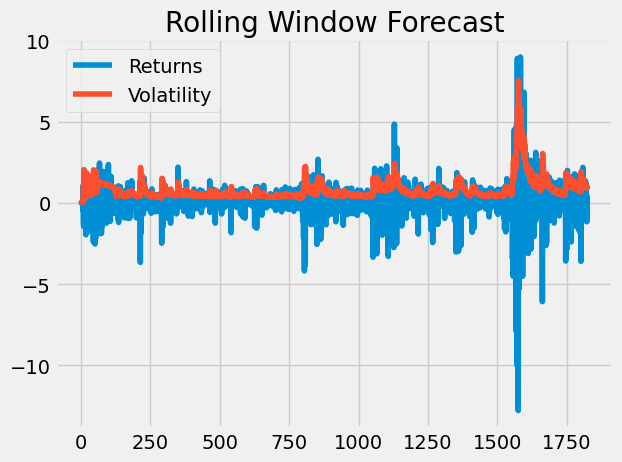

In [163]:
plt.plot(returns[-len(returns)-1:])
plt.plot(rolling)
plt.legend(['Returns','Volatility'])
plt.title('Rolling Window Forecast')
plt.show()

## Neural network with residuals

In [164]:
df["volatility"] = rolling
df['resid'] = res.resid

Date         High          Low         Open        Close   
1     2015-11-24  2094.120117  2070.290039  2084.419922  2089.139893  \
2     2015-11-25  2093.000000  2086.300049  2089.300049  2088.870117   
3     2015-11-26  2093.000000  2086.300049  2089.300049  2088.870117   
4     2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107   
5     2015-11-28  2093.290039  2084.129883  2088.820068  2090.110107   
...          ...          ...          ...          ...          ...   
1820  2020-11-16  3628.510010  3600.159912  3600.159912  3626.909912   
1821  2020-11-17  3623.110107  3588.679932  3610.310059  3609.530029   
1822  2020-11-18  3619.090088  3567.330078  3612.090088  3567.790039   
1823  2020-11-19  3585.219971  3543.840088  3559.409912  3581.870117   
1824  2020-11-20  3581.229980  3556.850098  3579.310059  3557.540039   

            Volume    Adj Close    Return  volatility     resid  
1     3.884930e+09  2089.139893  0.122125         NaN  0.057282  
2     2.852940e+09  2088.870117 -0.012914    0.000000 -0.077757  
3     2.852940e+09  2088.870117  0.000000    0.067520 -0.064843  
4     1.466840e+09  2090.110107  0.059344    0.033837 -0.005499  
5     1.466840e+09  2090.110107  0.000000    0.031292 -0.064843  
...            ...          ...       ...         ...       ...  
1820  5.281980e+09  3626.909912  1.158073    0.953676  1.093230  
1821  4.799570e+09  3609.530029 -0.480344    0.994693 -0.545187  
1822  5.274450e+09  3567.790039 -1.163121    0.897561 -1.227964  
1823  4.347200e+09  3581.870117  0.393868    1.031711  0.329025  
1824  2.236662e+09  3557.540039 -0.681574    0.854724 -0.746417  

[1824 rows x 10 columns]

In [213]:
ignore_cols = ['Date','High','Low','Close','Volume','Adj Close','volatility']
train_set = df.drop(columns = ignore_cols).dropna()[:1743]
test_set = df.drop(columns = ignore_cols).dropna()[1743:]
num_cols = train_set.shape[1]
df.drop(columns = ignore_cols)

Open    Return     resid
1     2084.419922  0.122125  0.057282
2     2089.300049 -0.012914 -0.077757
3     2089.300049  0.000000 -0.064843
4     2088.820068  0.059344 -0.005499
5     2088.820068  0.000000 -0.064843
...           ...       ...       ...
1820  3600.159912  1.158073  1.093230
1821  3610.310059 -0.480344 -0.545187
1822  3612.090088 -1.163121 -1.227964
1823  3559.409912  0.393868  0.329025
1824  3579.310059 -0.681574 -0.746417

[1824 rows x 3 columns]

In [214]:
test_set

Open    Return     resid
1744  3507.439941  0.749683  0.684840
1745  3543.760010  1.524905  1.460062
1746  3564.739990 -3.575759 -3.640602
1747  3453.600098 -0.816628 -0.881471
1748  3453.600098  0.000000 -0.064843
...           ...       ...       ...
1820  3600.159912  1.158073  1.093230
1821  3610.310059 -0.480344 -0.545187
1822  3612.090088 -1.163121 -1.227964
1823  3559.409912  0.393868  0.329025
1824  3579.310059 -0.681574 -0.746417

[81 rows x 3 columns]

In [215]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = train_set
training_set_scaled['Open'] = sc.fit_transform(np.array(train_set.Open).reshape(-1,1))
training_set_scaled = np.array(training_set_scaled)

In [216]:
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60: i])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], num_cols))
X_train.shape, y_train.shape

((1683, 60, 3), (1683,))

In [217]:
def get_model(X_train):
    regressor = keras.Sequential()
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
    regressor.add(Dropout(rate = 0.2))
    ##add 2nd lstm layer
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(rate = 0.2))
    ##add 3rd lstm layer
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(rate = 0.2))
    ##add 4th lstm layer
    regressor.add(LSTM(units = 50, return_sequences = False))
    regressor.add(Dropout(rate = 0.2))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor

In [218]:
regressor = get_model(X_train)
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)

Epoch 1/100
53/53 [==============================] - 7s 60ms/step - loss: 0.0216
Epoch 2/100
53/53 [==============================] - 3s 60ms/step - loss: 0.0038
Epoch 3/100
53/53 [==============================] - 3s 62ms/step - loss: 0.0031
Epoch 4/100
53/53 [==============================] - 3s 61ms/step - loss: 0.0039
Epoch 5/100
53/53 [==============================] - 3s 61ms/step - loss: 0.0033
Epoch 6/100
53/53 [==============================] - 3s 59ms/step - loss: 0.0025
Epoch 7/100
53/53 [==============================] - 3s 60ms/step - loss: 0.0022
Epoch 8/100
53/53 [==============================] - 3s 60ms/step - loss: 0.0026
Epoch 9/100
53/53 [==============================] - 3s 61ms/step - loss: 0.0024
Epoch 10/100
53/53 [==============================] - 3s 61ms/step - loss: 0.0021
Epoch 11/100
53/53 [==============================] - 3s 59ms/step - loss: 0.0021
Epoch 12/100
53/53 [==============================] - 3s 60ms/step - loss: 0.0023
Epoch 13/100
53/53 [=====

In [219]:
inputs = df.drop(columns = ignore_cols).dropna()[len(df)-len(test_set)- 60:].values
#inputs = inputs.reshape(-1,1)
inputs[:,0] = sc.transform(np.array(inputs[:,0]).reshape(-1,1)).flatten()

In [220]:
X_test = []
for i in range(60, len(inputs)): 
    X_test.append(inputs[i-60: i])
X_test = np.array(X_test)
#make numpy array as 3D , adding num of indicator
X_test = np.reshape(X_test, newshape = (X_test.shape[0], X_test.shape[1], num_cols))

In [221]:
len(X_test)

81

In [222]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

3/3 [==============================] - 1s 16ms/step


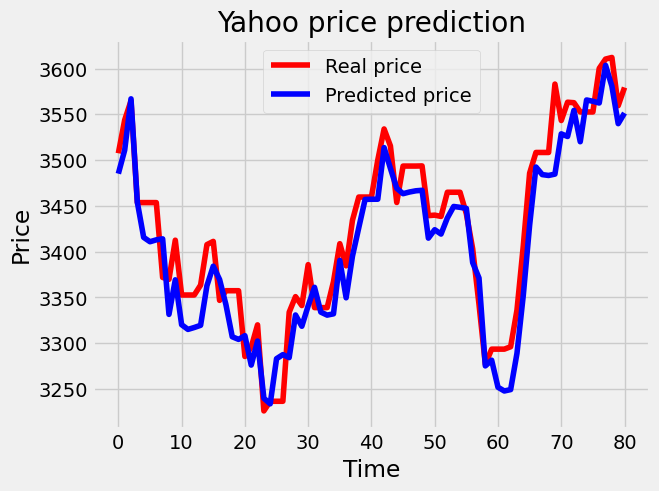

In [223]:
plt.plot(test_set.Open.reset_index(drop=True), color = 'red', label = 'Real price')
plt.plot(predicted_stock_price[:,0], color = 'blue', label = 'Predicted price')
plt.title('Yahoo price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

<Axes: >

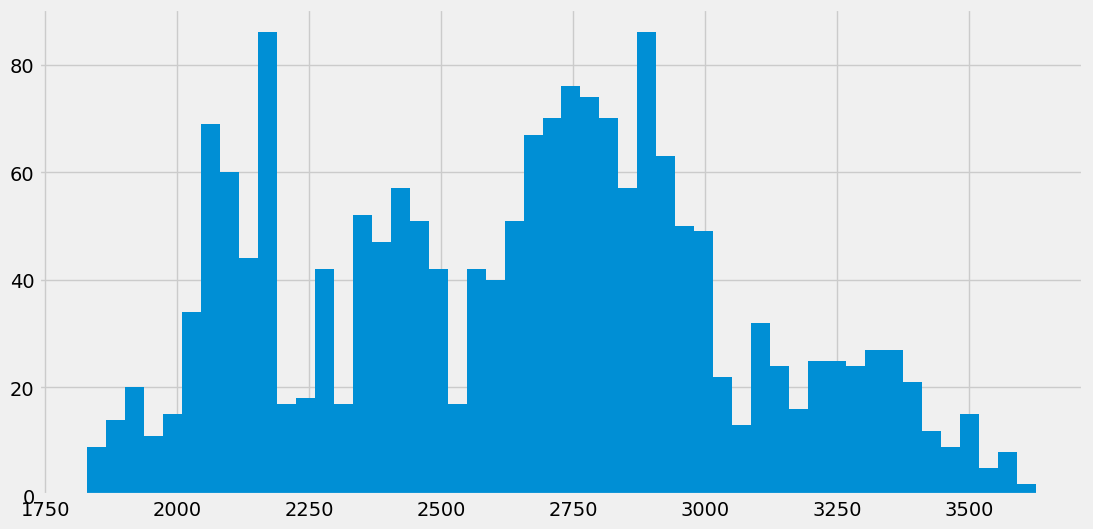

In [124]:
df.Close.hist(bins=50)

In [125]:
from statistics import stdev
mean=[]
std=[]
    
for i in range(0,10):
    mean.append(df['High'].iloc[(i*182):(i*182)+182].mean())
    std.append(stdev(df['High'].iloc[(i*182):(i*182)+182]))

In [126]:
pd.concat([pd.DataFrame(mean,columns=['mean']),pd.DataFrame(std,columns=['std'])], axis=1)


mean         std
0  2019.134354   70.865380
1  2148.526655   35.827225
2  2324.050669   59.749476
3  2490.746031   55.874803
4  2712.102919   62.449187
5  2816.055814   68.390616
6  2754.828835  131.989662
7  2966.638355   74.524073
8  3044.811746  267.692547
9  3312.705269  165.456385

In [127]:
from statsmodels.tsa.seasonal import seasonal_decompose

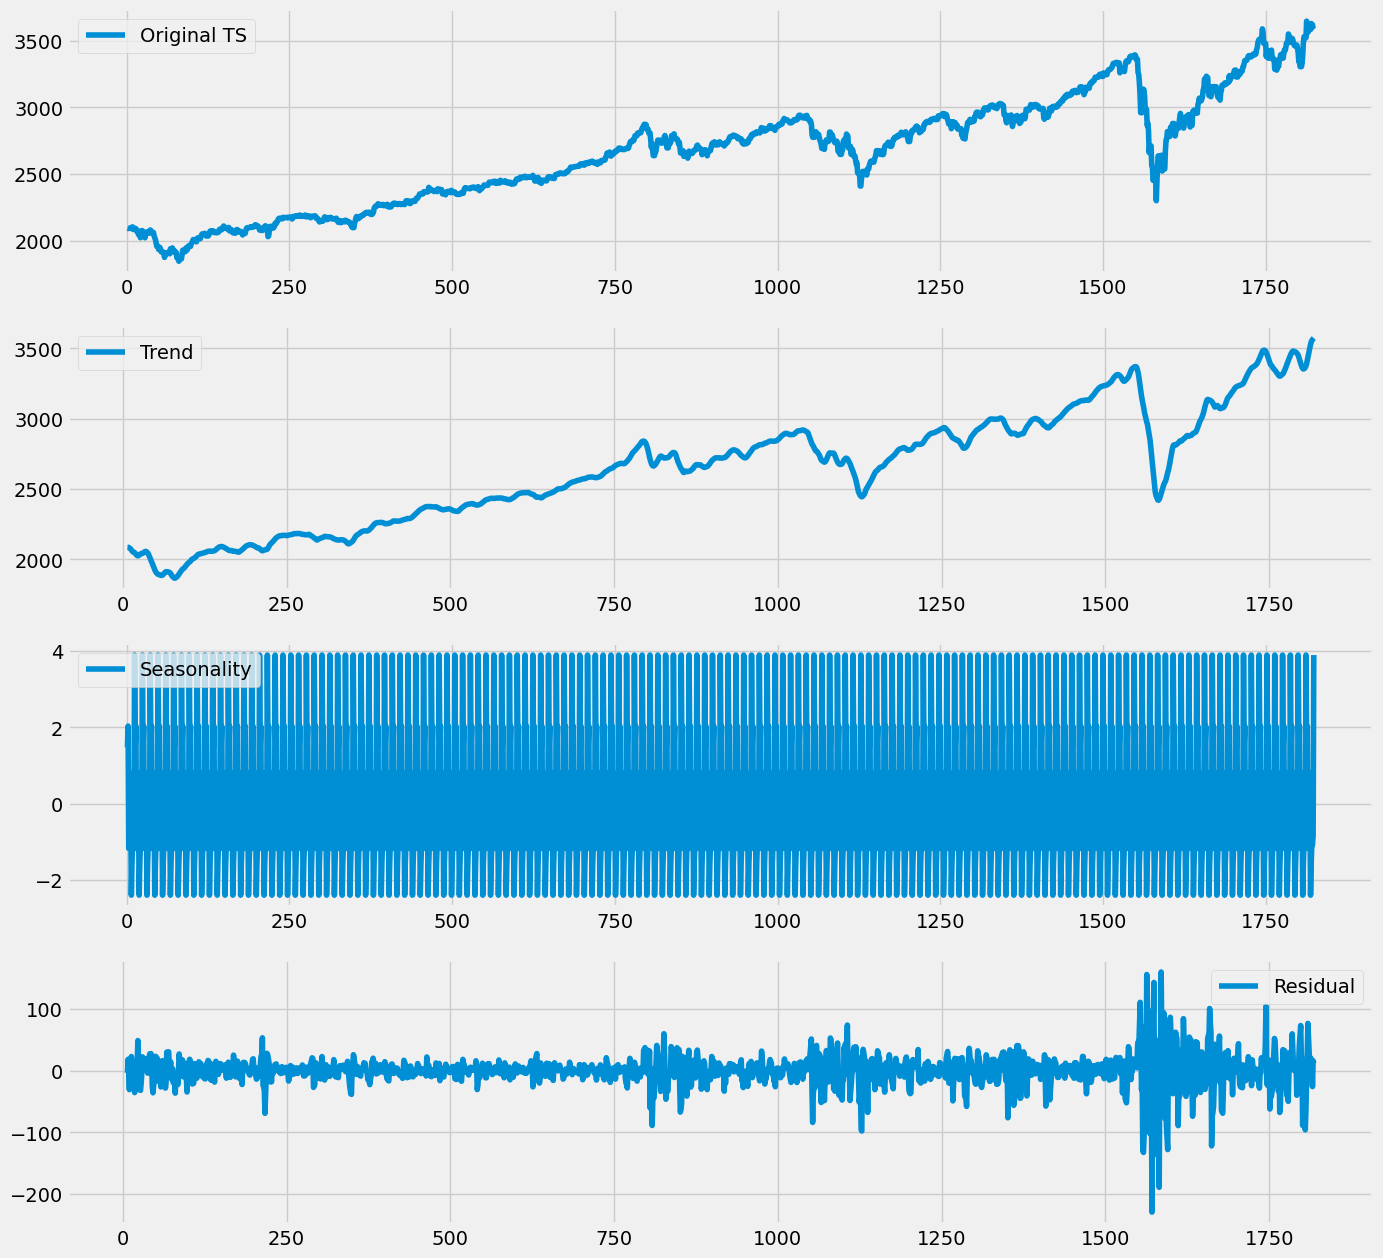

In [130]:
decompose_add=seasonal_decompose(df['Close'], model='additive', period=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(df['High'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

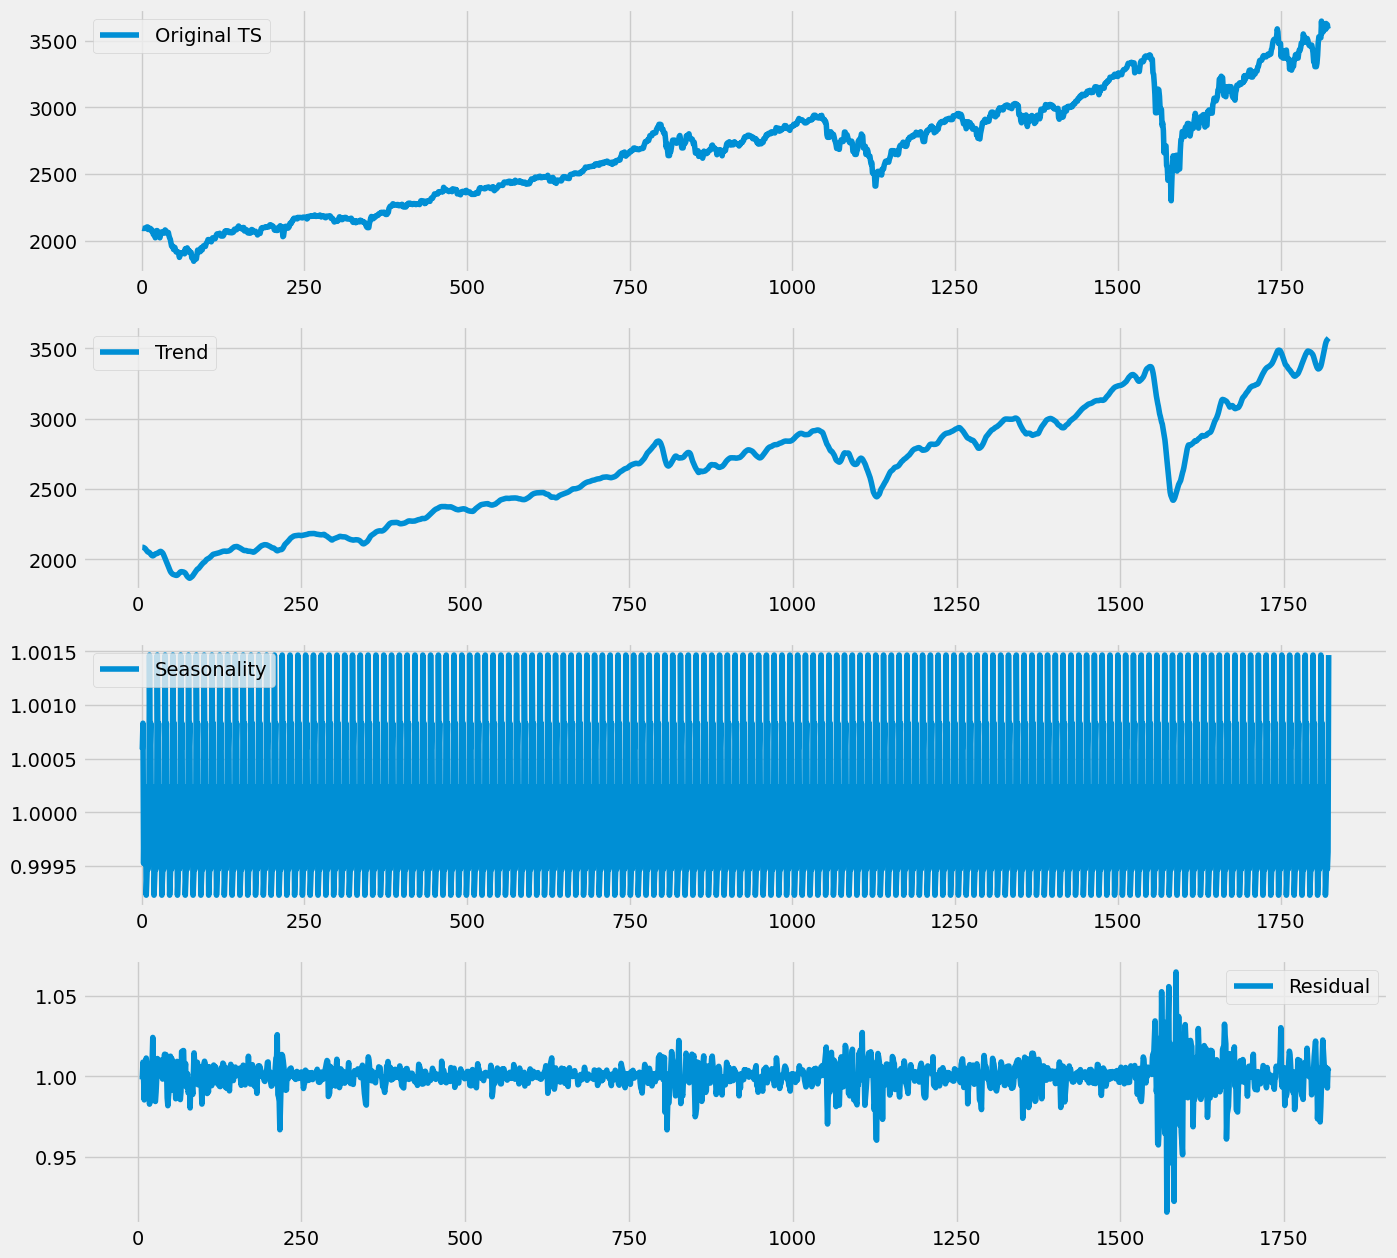

In [131]:
decompose_mul=seasonal_decompose(df['Close'], model='multiplicative', period=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(df['High'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_mul.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_mul.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_mul.resid, label='Residual')
plt.legend(loc='best')

In [132]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

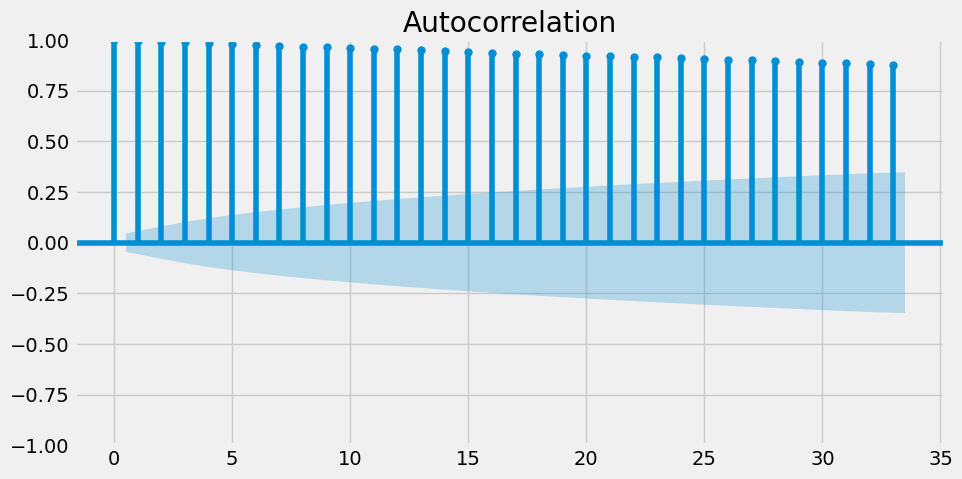

In [134]:
plt.rc("figure", figsize=(10,5))
plot_acf(df['Close'])
print()

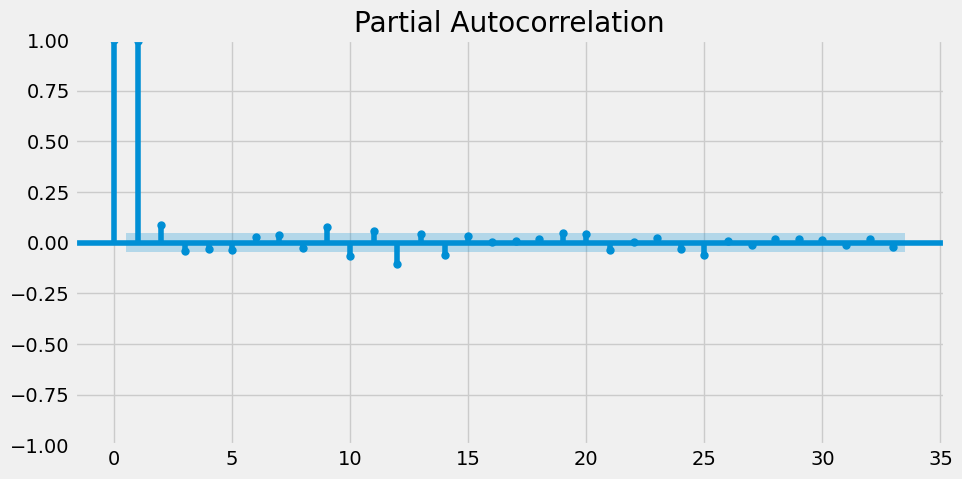

In [135]:
plt.rc("figure", figsize=(10,5))
plot_pacf(df['Close'])
print()

In [136]:
from statsmodels.tsa.stattools import adfuller

In [137]:
result = adfuller(df['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.924926
p-value: 0.779653
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [138]:
from numpy import log

result = adfuller(log(df['Close']))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.144006
p-value: 0.697208
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [176]:
new_df=df['Close'].iloc[:-4]

In [177]:
new_df

1       2089.139893
2       2088.870117
3       2088.870117
4       2090.110107
5       2090.110107
           ...     
1816    3537.010010
1817    3585.149902
1818    3585.149902
1819    3585.149902
1820    3626.909912
Name: Close, Length: 1820, dtype: float64

In [178]:
train_len = math.ceil(len(new_df)*0.8)
train_len

1456

In [179]:
window=10
train_data = new_df[0:train_len]

X_train=[]
Y_train=[]

for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i])
    Y_train.append(train_data[i])

In [180]:
X_train, Y_train= np.array(X_train), np.array(Y_train)

In [181]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1446, 10, 1)

In [182]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [183]:
model=Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                10400     
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dense_4 (Dense)             (None, 1)                 26        
                                                                 
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________


In [185]:
test_data = new_df[train_len-window:]

X_val=[]
Y_val=[] 

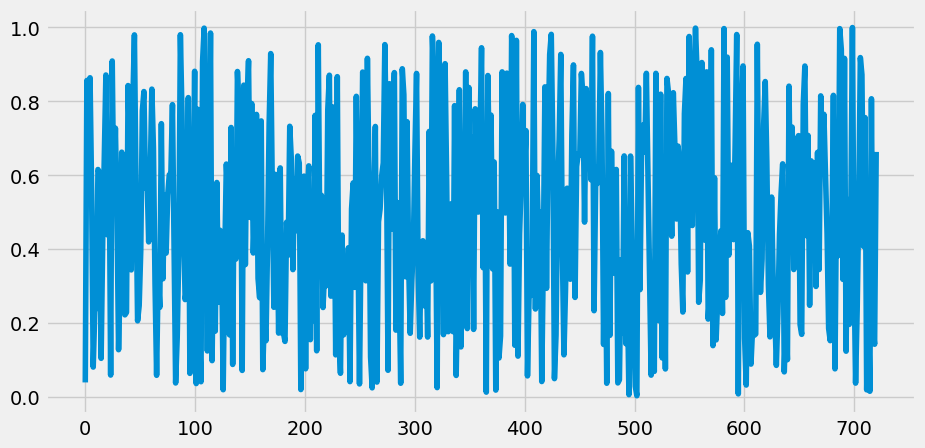

In [192]:
grid = np.linspace(0, 720, 500)
noise = np.random.rand(500)
result_curve =  noise
plt.plot(grid, result_curve)

In [193]:
df

Date         High          Low         Open        Close   
1     2015-11-24  2094.120117  2070.290039  2084.419922  2089.139893  \
2     2015-11-25  2093.000000  2086.300049  2089.300049  2088.870117   
3     2015-11-26  2093.000000  2086.300049  2089.300049  2088.870117   
4     2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107   
5     2015-11-28  2093.290039  2084.129883  2088.820068  2090.110107   
...          ...          ...          ...          ...          ...   
1820  2020-11-16  3628.510010  3600.159912  3600.159912  3626.909912   
1821  2020-11-17  3623.110107  3588.679932  3610.310059  3609.530029   
1822  2020-11-18  3619.090088  3567.330078  3612.090088  3567.790039   
1823  2020-11-19  3585.219971  3543.840088  3559.409912  3581.870117   
1824  2020-11-20  3581.229980  3556.850098  3579.310059  3557.540039   

            Volume    Adj Close    Return  volatility     resid  
1     3.884930e+09  2089.139893  0.122125         NaN  0.057282  
2     2.852940e+09  2088.870117 -0.012914    0.000000 -0.077757  
3     2.852940e+09  2088.870117  0.000000    0.067520 -0.064843  
4     1.466840e+09  2090.110107  0.059344    0.033837 -0.005499  
5     1.466840e+09  2090.110107  0.000000    0.031292 -0.064843  
...            ...          ...       ...         ...       ...  
1820  5.281980e+09  3626.909912  1.158073    0.953676  1.093230  
1821  4.799570e+09  3609.530029 -0.480344    0.994693 -0.545187  
1822  5.274450e+09  3567.790039 -1.163121    0.897561 -1.227964  
1823  4.347200e+09  3581.870117  0.393868    1.031711  0.329025  
1824  2.236662e+09  3557.540039 -0.681574    0.854724 -0.746417  

[1824 rows x 10 columns]

In [16]:
df.index = pd.to_datetime(df.index)

In [19]:
df.columns = ['Close price']

In [ ]:
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
df.iplot()

In [29]:
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose

# Assume df is your pandas DataFrame
result = seasonal_decompose(df, model='multiplicative')

# Create separate traces for the trend, seasonal, and residual components
trend = go.Scatter(y=result.trend, mode='lines', name='Trend')
seasonal = go.Scatter(y=result.seasonal, mode='lines', name='Seasonal')
residual = go.Scatter(y=result.resid, mode='lines', name='Residual')

# Combine the traces and create a Plotly figure
fig = go.Figure(data=[trend, seasonal, residual])

# Show the plot
fig.show()

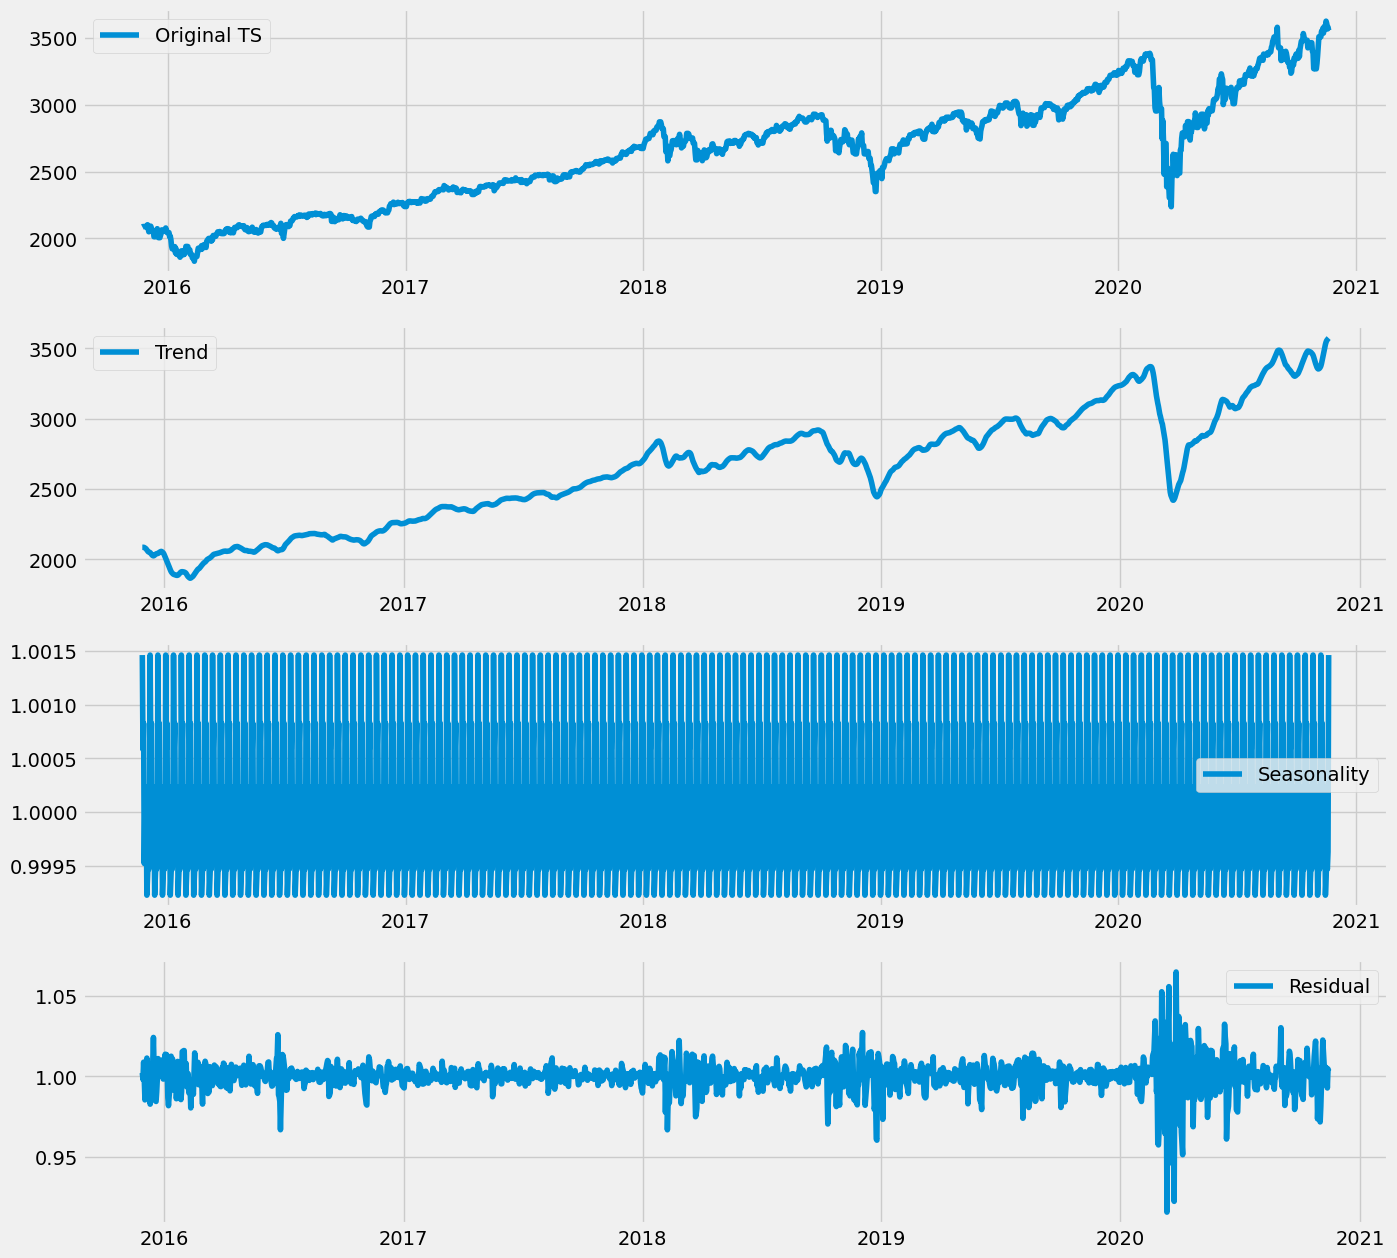

In [33]:
result=seasonal_decompose(df, model='multiplicative', period=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(df, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(result.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='best')

In [39]:
from pmdarima import auto_arima
stepwise_model = auto_arima(df, start_p=1, start_q=1,
                           max_p=6, max_q=6, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.93 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=18569.028, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=17786.304, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.34 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=18383.482, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=17594.699, Time=1.62 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=14.42 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.63 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=17648.395, Time=1.12 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=17585.791, Time=1.87 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=17777.271, Time=0.63 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=15.73 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.39 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=17576.315, Time=2.12 sec
 ARIMA(3,1,0)(1,1,0)[12]             : 

In [72]:
train = df.loc['2015-01-01':'2020-08-31']
test = df.loc['2020-09-01':]

In [74]:
stepwise_model.fit(train)

ARIMA(order=(4, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [75]:
print(stepwise_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1744
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -8349.501
Date:                            Sun, 21 May 2023   AIC                          16713.002
Time:                                    16:38:42   BIC                          16751.197
Sample:                                11-23-2015   HQIC                         16727.129
                                     - 08-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1718      0.010    -17.452      0.000      -0.191      -0.153
ar.L2          0.0762      0.013   

In [76]:
future_forecast = stepwise_model.predict(n_periods=81)

In [77]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])

In [198]:
my_df = pd.concat([test,future_forecast],axis=1)

In [86]:
my_df = my_df.iloc[0:24,:]

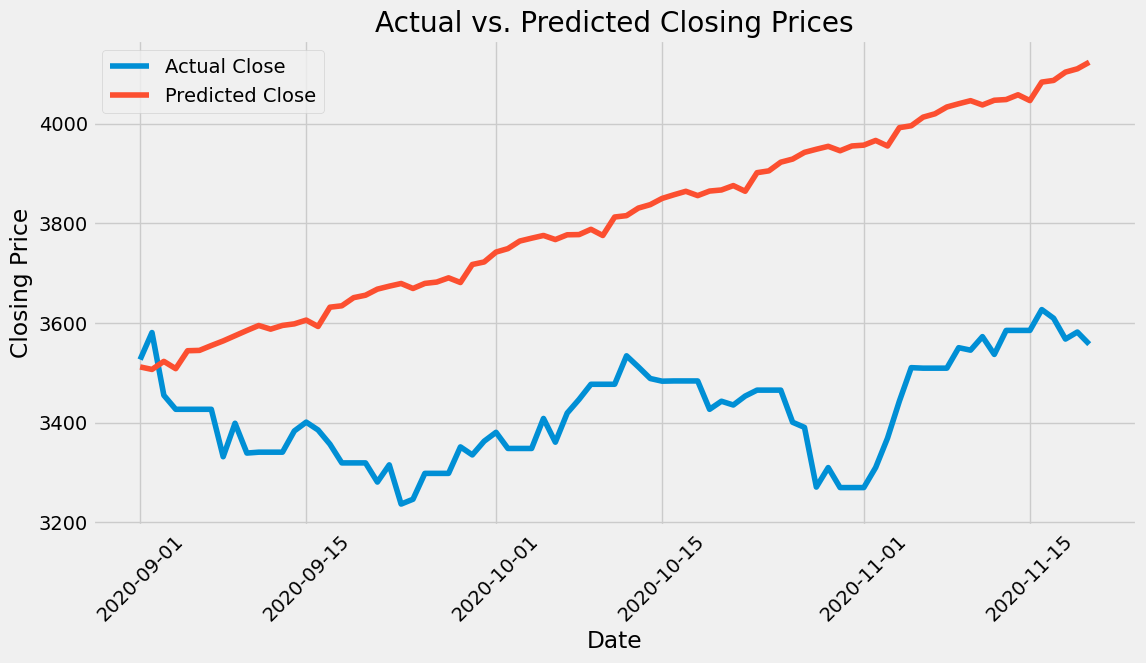

In [199]:
plt.figure(figsize=(12, 6))
plt.plot(my_df.index, my_df['Close'], label='Actual Close')
plt.plot(my_df.index, my_df['Prediction'], label='Predicted Close')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs. Predicted Closing Prices')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.show()

In [94]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
# fit in statsmodels
model = ETSModel(
    train,
    error="add",
    trend="add",
    seasonal="add",
    damped_trend=True,
    seasonal_periods=4,
)
fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.37701D+00    |proj g|=  8.99900D-01

At iterate    1    f=  4.80458D+00    |proj g|=  2.38248D-01

At iterate    2    f=  4.77486D+00    |proj g|=  1.80267D-01

At iterate    3    f=  4.70725D+00    |proj g|=  9.47369D-02

At iterate    4    f=  4.70002D+00    |proj g|=  1.10238D-01

At iterate    5    f=  4.69642D+00    |proj g|=  8.87656D-02

At iterate    6    f=  4.69453D+00    |proj g|=  5.02078D-02

At iterate    7    f=  4.69376D+00    |proj g|=  1.51995D-02

At iterate    8    f=  4.69366D+00    |proj g|=  8.53611D-03

At iterate    9    f=  4.69360D+00    |proj g|=  5.97371D-03

At iterate   10    f=  4.69354D+00    |proj g|=  3.72449D-03

At iterate   11    f=  4.69353D+00    |proj g|=  9.81082D-04

At iterate   12    f=  4.69353D+00    |proj g|=  4.93472D-04

At iterate   13    f=  4.6

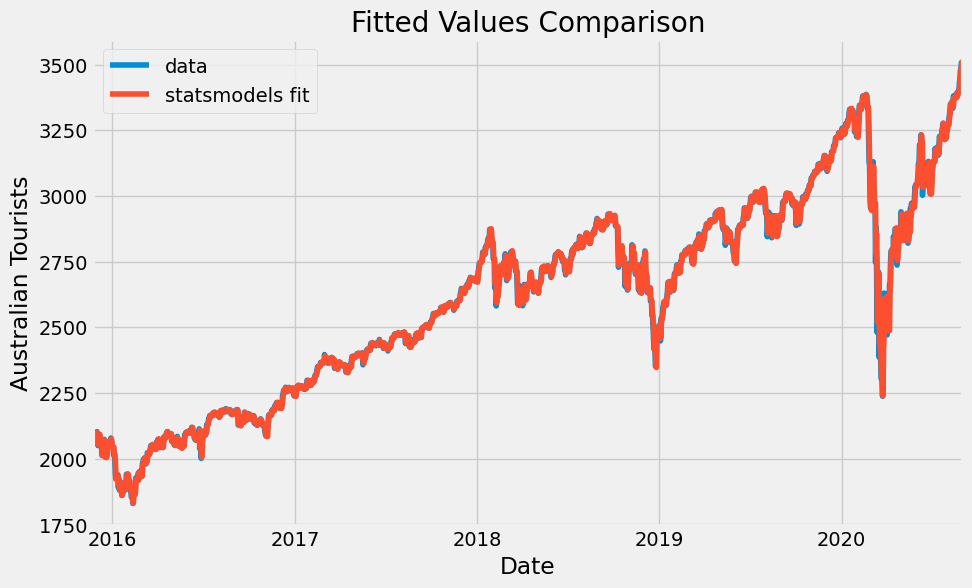

In [96]:
# Plotting
plt.figure(figsize=(10, 6))
train.plot(label="data")
fit.fittedvalues.plot(label="statsmodels fit")
plt.ylabel("Australian Tourists")
plt.title("Fitted Values Comparison")
plt.legend()
plt.show()

In [97]:
print(fit.summary())


                                 ETS Results                                  
Dep. Variable:                  Close   No. Observations:                 1744
Model:                      ETS(AAdA)   Log Likelihood               -8174.291
Date:                Sun, 21 May 2023   AIC                          16370.582
Time:                        17:05:15   BIC                          16430.685
Sample:                    11-23-2015   HQIC                         16392.804
                         - 08-31-2020   Scale                          689.737
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.7969        nan        nan        nan         nan         nan
smoothing_trend        0.0586        nan        nan        nan         nan         nan
smoothing_seasonal  

In [127]:
pred = fit.get_prediction(start="2020-09", end="2021-11-20")

In [129]:
my_ets_pred = pred.summary_frame(alpha=0.05)

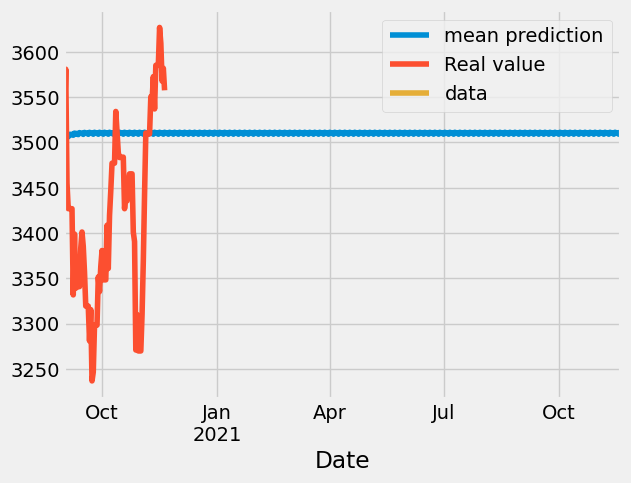

In [130]:
my_ets_pred["mean"].plot(label="mean prediction")
test.plot(label = "Real value")
pred.endog.plot(label="data")
plt.legend()

In [133]:
my_ets_pred[['mean']]

mean
2020-09-01  3505.689670
2020-09-02  3506.044473
2020-09-03  3506.952953
2020-09-04  3506.285902
2020-09-05  3508.980743
...                 ...
2021-11-16  3510.503921
2021-11-17  3510.520512
2021-11-18  3509.139949
2021-11-19  3511.263980
2021-11-20  3510.503921

[446 rows x 1 columns]

In [150]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
mse_ets = mean_squared_error(test, my_ets_pred[['mean']][0:81])
rmse_ets = np.sqrt(mse)

print("MSE:",mse_ets)
print("RMSE:", rmse_ets)

MSE: 17407.295964914334
RMSE: 131.93671196795202


In [151]:
# Calculate RMSE
mse_arima = mean_squared_error(my_df['Close'],my_df['Prediction'])
rmse_arima = np.sqrt(mse_arima)
print("MSE:",mse_arima)
print("RMSE:", rmse_arima)

MSE: 65710.02572473392
RMSE: 256.3396686522278


In [226]:
# Calculate RMSE
mse_dp = mean_squared_error(test_set.Open,predicted_stock_price[:,0])
rmse_dp = np.sqrt(mse_dp)
print("MSE:",mse_dp)
print("RMSE:", rmse_dp)

MSE: 1060.3317895090138
RMSE: 32.5627362104141


In [235]:
#result_df = pd.DataFrame([
    #{'Statistic': 'MSE_ets', 'Value': mse_ets},
    #{'Statistic': 'RMSE_ets', 'Value': rmse_ets},
    #{'Statistic': 'MSE_arima', 'Value': mse_arima},
    #{'Statistic': 'RMSE_arima', 'Value': rmse_arima},
    #{'Statistic': 'MSE_dp', 'Value': mse_dp},
    #{'Statistic': 'RMSE_dp', 'Value': rmse_dp}
#])


In [237]:
result_df = pd.DataFrame({
    'Statistic': ['MSE', 'RMSE'],
    'ETS': [mse_ets, rmse_ets],
    'ARIMA': [mse_arima, rmse_arima],
    'DeepLearning': [mse_dp, rmse_dp]
})


In [238]:
result_df

Statistic           ETS         ARIMA  DeepLearning
0       MSE  17407.295965  65710.025725   1060.331790
1      RMSE    131.936712    256.339669     32.562736

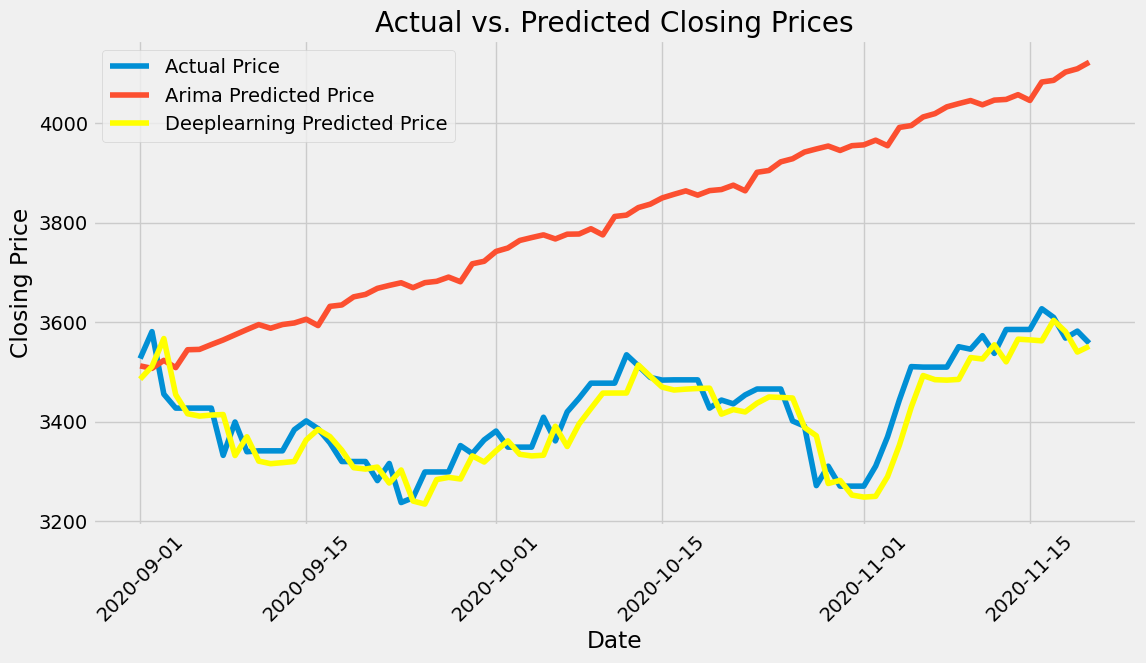

In [239]:
plt.figure(figsize=(12, 6))
plt.plot(my_df.index, my_df['Close'], label='Actual Price')
plt.plot(my_df.index, my_df['Prediction'], label='Arima Predicted Price')
plt.plot(my_df.index, my_df['dp_Prediction'], label='Deeplearning Predicted Price', color = "yellow" )
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs. Predicted Closing Prices')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.show()

Close   Prediction  dp_Prediction
Date                                               
2020-09-01  3526.649902  3511.917267    3485.168213
2020-09-02  3580.840088  3506.911694    3510.878662
2020-09-03  3455.060059  3523.050448    3566.910156
2020-09-04  3426.959961  3508.438973    3454.016113
2020-09-05  3426.959961  3544.391288    3415.625732
...                 ...          ...            ...
2020-11-16  3626.909912  4083.076080    3562.355713
2020-11-17  3609.530029  4086.475755    3603.518555
2020-11-18  3567.790039  4103.111041    3580.734619
2020-11-19  3581.870117  4109.698185    3539.805420
2020-11-20  3557.540039  4122.880431    3551.382080

[81 rows x 3 columns]